## Project Name: The Sweet Truth! 
### (Part 2)
This project aims at identifying the sweetners (natural or artificial) present in the ingredient list from a packaged food product. 

This project is divided in two sections: 
1. Sweetener detection from ingredient list. (*Details in the file - `sweetener_detector_from_text.ipynb`*) A list will be provided to the model as input from which the sweeteners will be identified.

2. (THIS FILE) Integrating this detector to an Optical Character Recognition (OCR) pipeline so that the text can be directly extracted from the images of the packaged food ingredients. 
    * Computer Vision using existing libraries. - *Pytesseract, OpenCV*
    * Text preprocessing - *SpaCy, Regular expression (Re)*
   
#### Steps I will be following in this file: 
1. Preprocessing an input image which contains ingredient list of packaged food items.
2. Extracting the text from the preprocessed image.
3. Preprocessing the extracting text so that it can be fed to our sweetener detector model prepared in `sweetener_detector_from_text.ipynb` and saved as `sweesweet_truth_detector.pkl` file.
4. Integrating our OCR pipline with the detector.
5. (Optional) Finding a way to annotate the image with detected sweeteners. 

Let's go!!

In [1]:
# necessary imports 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt


### 1. Image preprocessing.

Preparing our path for stored images.

My trial image for this file is the ingredient list of corn flakes taken from [open food facts](https://in.openfoodfacts.org/product/8901499010216/corn-flakes-kellogg-s).

In [2]:
data_dir = '/Users/bhawakshipunia/data_science_projects/hidden_sugar_detection/'
img_path = data_dir + 'corn_flakes.jpg'

In [3]:
from matplotlib.image import imread

(np.float64(-0.5), np.float64(1843.5), np.float64(495.5), np.float64(-0.5))

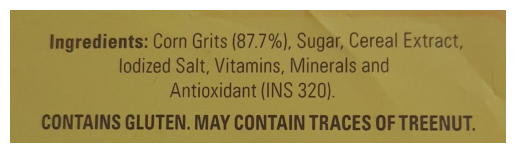

In [4]:
plt.imshow(imread(img_path)) 
plt.axis("off")

In [10]:
#!pip install OpenCV-python

A function to preprocess our image: 
* reading the image in grayscale.
* Smoothening out to de-noise it.
* Thresholding for improved text recognition. 

In [5]:
# image preprocessing 

import cv2

def preprocess_image(image_path):
    # Load the image in grayscale
    img = cv2.imread(image_path, 0)
    # Apply Gaussian blur to remove noise
    img = cv2.GaussianBlur(img, (5, 5), 0)
    # Thresholding for better text recognition
    _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    return img


(np.float64(-0.5), np.float64(1843.5), np.float64(495.5), np.float64(-0.5))

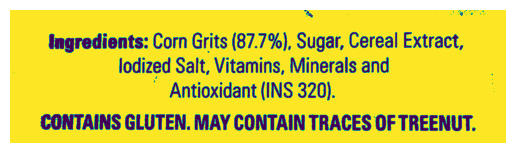

In [6]:
prep_img = preprocess_image(img_path)
plt.imshow(prep_img) 
plt.axis('off')

### 2. Text extraction from preprocessed image - OCR

In [26]:
#!pip install tesseract

In [23]:
#! pip install pytesseract

In [7]:
import pytesseract 

# Perform OCR on an image
text = pytesseract.image_to_string(prep_img)
print(text)

on

ingredients: Corn Grits (87.7%), Sugar, Cereal Extract,
lodized Salt, Vitamins, Minerals and
~ Antioxidant (INS 320).

CONTAINS GLUTEN. MAY CONTAIN TRACES OF TREENUT.



In [8]:
pytesseract.image_to_string(preprocess_image(img_path))

'on\n\ningredients: Corn Grits (87.7%), Sugar, Cereal Extract,\nlodized Salt, Vitamins, Minerals and\n~ Antioxidant (INS 320).\n\nCONTAINS GLUTEN. MAY CONTAIN TRACES OF TREENUT.\n'

### 3. Preprocessing the extracted text to be input-ready for our sweetener detector.

In [10]:
text.split('\n\n')

['on',
 'ingredients: Corn Grits (87.7%), Sugar, Cereal Extract,\nlodized Salt, Vitamins, Minerals and\n~ Antioxidant (INS 320).',
 'CONTAINS GLUTEN. MAY CONTAIN TRACES OF TREENUT.\n']

In [9]:
# selecting the ingredient section from the extracted text 

import re 

for i in range(len(text.split('\n\n'))):
    txt = text.split('\n\n')[i] # to separate out sections in the text
    txt = re.sub(r'\s+', ' ', txt.strip())  # to elminate line separations in each section 
    ings = re.findall(r'ingredients:.*', txt, re.IGNORECASE)  # picking out the ingredient list from the image
    if ings != []:
        print(ings[0])
        ing_list = ings[0] 

print(ing_list)


ingredients: Corn Grits (87.7%), Sugar, Cereal Extract, lodized Salt, Vitamins, Minerals and ~ Antioxidant (INS 320).
ingredients: Corn Grits (87.7%), Sugar, Cereal Extract, lodized Salt, Vitamins, Minerals and ~ Antioxidant (INS 320).


In [10]:
# i need to separate out the ingredients with commas so that they resemble the input lists we've been working with 
# for this, i need to split the text based on ':' and 'and'. 

rx = re.compile(r"\s*(?:\b(?:and|or)\b|[,:])\s*") 
rev_lst = rx.split(ing_list)

result_string = ", ".join(rev_lst)
print(result_string)

ingredients, Corn Grits (87.7%), Sugar, Cereal Extract, lodized Salt, Vitamins, Minerals, ~ Antioxidant (INS 320).


### 4. Integration of the OCR pipeline with the model.

Testing this extracted list with our function prepared in the custom module - `sweet_truth_from_list(list, model)`. 

In [11]:
from module_detector import * # to import all functions

In [12]:
import joblib
model = joblib.load('sweet_truth_detector.pkl')

In [13]:
sweet_truth_from_list(result_string, model)

,Ingredient,Confidence
1,sugar,94.900222


Yayy!! in a way, we have successfully performed image-to-sweetener end-to-end detection! 

Let us prepare a function for this entire process now by using just the image path and the classification model as the input.

This function will have steps: 
* Takes image path as input.
* preprocessing the image using `preprocess_image(image_path)` function for an accurate OCR. 
* performs OCR
* picking out the ingredient section from the text extracted. No allergen information. 
* Preprocessing this text into our originally used input list (with only commas separating the ingredients.
* Subjecting this list to our `sweet_truth_from_list(result_string, model)` function to perform the sweetener detection.

After this is up and running, I will try to find ways to modify the way the output is being presented. Maybe I will try to incorporate the output in the original image itself while highlighting the model's confidence in its prediction. 

In [14]:
import pytesseract 
import re 

def image_to_sweetener_detector(image_path, model): 

    # Step 1: show the original image 
    plt.imshow(imread(image_path)) 
    plt.axis("off")    
    plt.show()
    
    # Step 2: preprocess the image - noise removal, grayscaling, etc.
    # we use our function ppreprocess_image(path) for this 
    img = preprocess_image(image_path)

    # Step 3: performing OCR on the preprocessed image 'img'
    extracted_text = pytesseract.image_to_string(img)
    #print(extracted_text)

    extracted_text = re.sub(r'\s+', ' ', extracted_text.strip())

    # this is an additional step, if by any chance, the OCR wasn't successful due to possible poor image resolution. 
    ing_list = None
    
    # Step 4: picking out the ingredient section from this extracted text
    ings = re.findall(r'ingredients.*', extracted_text, re.IGNORECASE)  # picking out the ingredient list from the image
    if ings != []:
            ing_list = ings[0] # this is our desired ingredient list we needed from the image

    if ing_list:
        # Step 5: preprocessing this list so that it is aligned with the desired input format for our detector 
        rx = re.compile(r"\s*(?:\b(?:and|or)\b|[,:])\s*") 
        rev_lst = rx.split(ing_list)
        
        result_string = ", ".join(rev_lst)
    
        # finally, comes our detector now 
        return sweet_truth_from_list(result_string, model)
    else: 
        return print("The image is not clear enough for appropriate text extraction.")


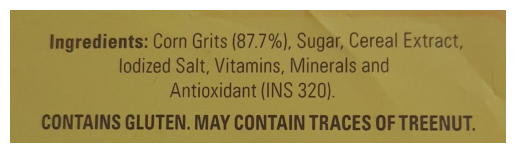

,Ingredient,Confidence
1,sugar,94.900222


In [15]:
image_to_sweetener_detector(img_path, model)

Testing it on an unclear image, to check if the function works. 

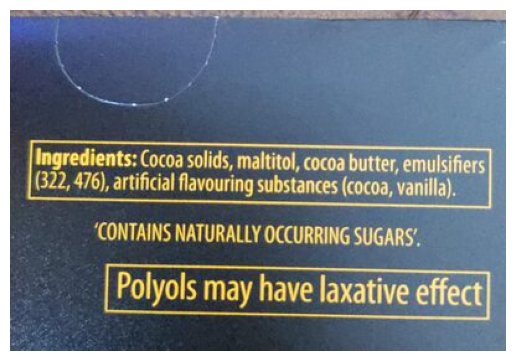

The image is not clear enough for appropriate text extraction.


In [16]:
path = data_dir + 'sugar_free_chocolate.jpg'

image_to_sweetener_detector(path, model)

We can see that our function also works if the OCR wasn't successful and it shows up the error.  

#### Great!! The function works perfectly! 

### 5. Annotating the image with the detected sweeteners.

Now, is there a way we could present our output on the image itself?

In [11]:
def combine_boxes(boxes, x_threshold=40, y_threshold=20):
    """
    Combine horizontally aligned bounding boxes based on a threshold.

    Args:
        boxes (list of tuples): List of bounding boxes as (x1, y1, x2, y2).
        x_threshold (int): Maximum gap allowed between boxes on the x-axis.
        y_threshold (int): Maximum difference in y-coordinates to consider boxes on the same line.

    Returns:
        list of tuples: Combined bounding boxes.
    """
    # Sort boxes by y (top) coordinate and then by x (left) coordinate
    boxes = sorted(boxes, key=lambda b: (b[0], b[1]))

    #print(boxes)

    combined_boxes = []
    current_box = boxes[0]

    for box in boxes[1:]:
        # Check if the boxes are on the same line (y-coordinate proximity)
        if abs(current_box[1] - box[1]) < y_threshold:
            # Check if the boxes are close enough on the x-axis
            if abs(box[0] - current_box[2]) < x_threshold:
                # Merge the current box with the new box
                current_box = (
                    min(current_box[0], box[0]),  # x1
                    min(current_box[1], box[1]),  # y1
                    max(current_box[2], box[2]),  # x2
                    max(current_box[3], box[3]),  # y2
                )
            else:
                # Add the current box to the result and start a new one
                combined_boxes.append(current_box)
                current_box = box
            #print("x_threshold loop", current_box)
        else:
            # Add the current box to the result and start a new one
            combined_boxes.append(current_box)
            current_box = box
            #print("y_threshold loop", current_box)

    # Add the last box
    combined_boxes.append(current_box)
    return combined_boxes


In [12]:
import re

def annotate_image_with_sweeteners(image_path, model):

    def clean_text(text):
        return re.sub(r'[^a-zA-Z0-9]', ' ', text.lower().strip())
    
    # showing the original image 
    plt.imshow(imread(image_path)) 
    plt.axis('off') 
    plt.show()
    
    # Step 1: Preprocess the image
    img = preprocess_image(image_path)
    
    # Step 2: Extract bounding box data using Pytesseract
    data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
    
    # Load the original image in color (for annotation)
    original_img = cv2.imread(image_path)
    
    # Step 3: Perform OCR and sweetener detection
    extracted_text = pytesseract.image_to_string(img)

    extracted_text = re.sub(r'\s+', ' ', extracted_text.strip())

    # this is an additional step, if by any chance, the OCR wasn't successful due to possible poor image resolution. 
    ing_list = None
    
    # Step 4: picking out the ingredient section from this extracted text
    ings = re.findall(r'ingredients.*', extracted_text, re.IGNORECASE)  # picking out the ingredient list from the image
    if ings != []:
            ing_list = ings[0] # this is our desired ingredient list we needed from the image

    if ing_list:
        # Preprocess the extracted ingredient list
        rx = re.compile(r"\s*(?:\b(?:ingredient|ingredients|and|or)\b|[,:])\s*") 
        #rx = re.compile(r"\s*(?:\b(?:ingredient|ingredients|and|or)\b|[,:]|\s+)\s*")
        rev_lst = rx.split(ing_list)
        result_string = ", ".join(rev_lst)
        
        # Detect sweeteners
        sweeteners_df = sweet_truth_from_list(result_string, model)
        
        if isinstance(sweeteners_df, pd.DataFrame):
            #detected_sweeteners = sweeteners_df['Ingredient'].str.lower().tolist()

            # Step 4: Draw rectangles around detected sweeteners
            detected_sweeteners = []
            for ingredient in sweeteners_df['Ingredient'].str.lower().tolist(): 
                for t in ingredient.split():
                    detected_sweeteners.append(t)

            n_boxes = len(data['text'])
            detected_boxes = []
            for i in range(n_boxes):
                # Clean the OCR word
                word = clean_text(data['text'][i])
            
                # Skip empty or invalid words
                if not word or len(word) < 3:
                    continue
            
                # Check for bidirectional substring matching with noise removal
                if any(word in sweetener or sweetener in word for sweetener in detected_sweeteners):
                    x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
                    entry = (x, y, x + w, y + h)
                    detected_boxes.append(entry)
            
            # Combine nearby boxes
            combined_boxes = combine_boxes(detected_boxes)
            #print(combine_boxes)
            
            # Draw combined boxes on the image
            for (x1, y1, x2, y2) in combined_boxes:
                cv2.rectangle(original_img, (x1, y1), (x2, y2), (0, 0, 255), 3)

            
            annotated_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
            plt.imshow(annotated_img_rgb)
            plt.axis('off')  # Hide axes
            plt.title("Annotated Image with Detected Sweeteners")
            plt.show()

            return sweeteners_df
        else:
            print("No sweeteners detected.")
    else:
        print("The image is not clear enough for appropriate text extraction.")


Testing the entire sweetener detector model on various products now. (The images are either self-clicked or otherwise the source is  mentioned.) 
1. Corn flakes - from [open food facts](https://in.openfoodfacts.org/product/8901499010216/corn-flakes-kellogg-s)
2. Toothpaste
3. Moong dal - [open food facts](https://in.openfoodfacts.org/product/8904004403718/moong-dal-haldiram-s)

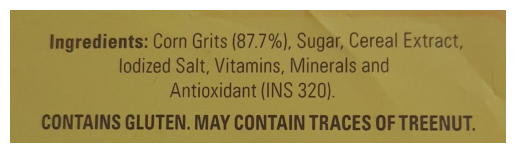

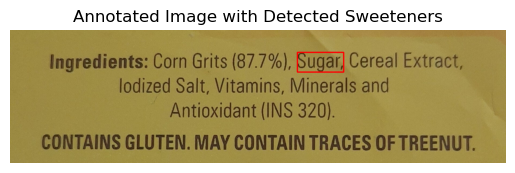

,Ingredient,Confidence
1,sugar,94.900222


In [13]:
annotate_image_with_sweeteners(img_path, model)

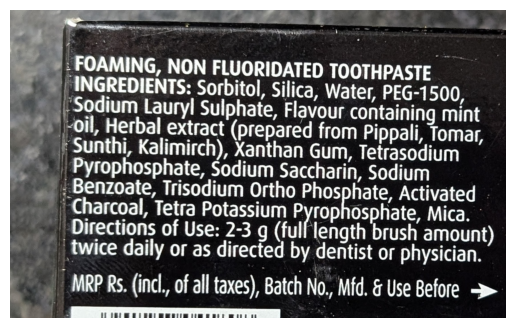

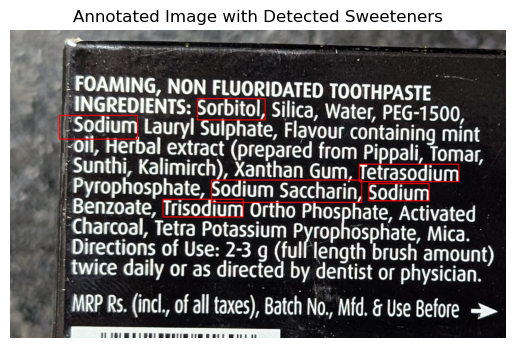

,Ingredient,Confidence
1,sorbitol,90.909091
2,sodium saccharin,86.249524


In [14]:
# specifying its path 
toothpaste_path = data_dir + 'toothpaste.jpg'

# now the moment of truth 
annotate_image_with_sweeteners(toothpaste_path, model)

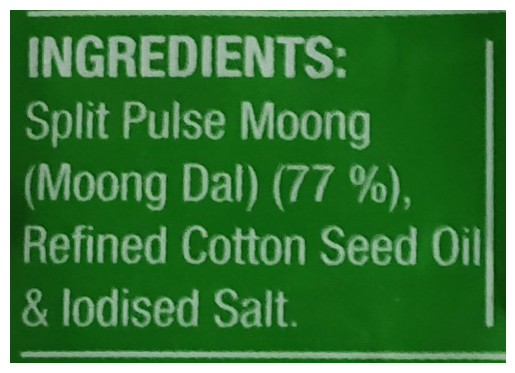

No sweeteners detected.


In [19]:
# specifying the path 
moong_dal_path = data_dir + 'moong_dal.jpg'

# now the moment of truth 
annotate_image_with_sweeteners(moong_dal_path, model)

## Perfect!! 

Our 'Sweet Truth Detector' is now in action!! Let me now update the module with these two functions: 
1. Image to sweetener identification without annotations in the image
2. Annotated image with sweeteners.

I will create a new file where the functions prepared in the module will be tested along with some additional real-world examples. 